In [16]:
import MDAnalysis as mda
import numpy.linalg
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from MDAnalysis.analysis import pca, align

psf = "../../data/ProG_20K/step1_pdbreader.psf"
dcd = "../../../protein-VAE-main_org/charmm-gui_3GB1/gromacs/pro_align.xtc"

/home/shrishti/anaconda3/envs/pro_vae/lib/python3.7/site-packages/Bio/pairwise2.py:283: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  BiopythonDeprecationWarning,


# end-to-end distance

In [ ]:
def endtoend(psf,dcd):
    u = mda.Universe(psf,dcd)  # always start with a Universe
    nterm = u.select_atoms('protein and name N')[0]  # can access structure via segid (s4AKE) and atom name
    cterm = u.select_atoms('protein and name C')[-1]  # ... takes the last atom named 'C'
    bb = u.select_atoms('protein and backbone')  # a selection (a AtomGroup)
    ete = []
    frame = []
    for ts in u.trajectory:  # iterate through all frames
        r = cterm.position - nterm.position  # end-to-end vector from atom positions
        d = numpy.linalg.norm(r)   # end-to-end distance
        frame.append(ts.frame)
        ete.append(d)
    return frame, ete

# PCA

Optionally align each frame in your trajectory to the first frame.

In [17]:
aligner = align.AlignTraj(u, u, select='backbone', in_memory=True).run()

Construct a 3N x 3N covariance for the N atoms in your trajectory. Optionally, you can provide a mean; otherwise the covariance is to the averaged structure over the trajectory.

In [18]:
pc = pca.PCA(u, select='backbone', align=True, mean=None, n_components=None).run()

Diagonalise the covariance matrix. The eigenvectors are the principal components, and their eigenvalues are the associated variance.

In [19]:
backbone = u.select_atoms('backbone')
n_bb = len(backbone)
print('There are {} backbone atoms in the analysis'.format(n_bb))
print(pc.p_components.shape)

There are 223 backbone atoms in the analysis
(669, 669)


/home/shrishti/anaconda3/envs/pro_vae/lib/python3.7/site-packages/MDAnalysis/analysis/pca.py:321: DeprecationWarning: The `p_components` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.p_components` instead.
  warnings.warn(wmsg, DeprecationWarning)


In [30]:
print(f"PC1: {pc.variance[0]:.5f}")
for i in range(669):
    print(f"Cumulated variance: {pc.variance[i]:.3f}",i)

PC1: 24.92463
Cumulated variance: 24.925 0
Cumulated variance: 14.579 1
Cumulated variance: 6.402 2
Cumulated variance: 5.097 3
Cumulated variance: 3.645 4
Cumulated variance: 3.491 5
Cumulated variance: 2.744 6
Cumulated variance: 2.410 7
Cumulated variance: 2.359 8
Cumulated variance: 2.063 9
Cumulated variance: 1.742 10
Cumulated variance: 1.599 11
Cumulated variance: 1.342 12
Cumulated variance: 1.243 13
Cumulated variance: 1.175 14
Cumulated variance: 1.080 15
Cumulated variance: 1.051 16
Cumulated variance: 0.940 17
Cumulated variance: 0.831 18
Cumulated variance: 0.767 19
Cumulated variance: 0.737 20
Cumulated variance: 0.710 21
Cumulated variance: 0.655 22
Cumulated variance: 0.641 23
Cumulated variance: 0.578 24
Cumulated variance: 0.556 25
Cumulated variance: 0.538 26
Cumulated variance: 0.534 27
Cumulated variance: 0.478 28
Cumulated variance: 0.469 29
Cumulated variance: 0.420 30
Cumulated variance: 0.411 31
Cumulated variance: 0.398 32
Cumulated variance: 0.376 33
Cumulate

/home/shrishti/anaconda3/envs/pro_vae/lib/python3.7/site-packages/MDAnalysis/analysis/pca.py:329: DeprecationWarning: The `variance` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.variance` instead.
  warnings.warn(wmsg, DeprecationWarning)


Sort the eigenvalues so that the principal components are ordered by variance.

In [29]:
for i in range(669):
    print(f"Cumulated variance: {pc.cumulated_variance[i]:.3f}",i)



Cumulated variance: 0.249 0
Cumulated variance: 0.395 1
Cumulated variance: 0.459 2
Cumulated variance: 0.510 3
Cumulated variance: 0.547 4
Cumulated variance: 0.582 5
Cumulated variance: 0.609 6
Cumulated variance: 0.633 7
Cumulated variance: 0.657 8
Cumulated variance: 0.677 9
Cumulated variance: 0.695 10
Cumulated variance: 0.711 11
Cumulated variance: 0.724 12
Cumulated variance: 0.737 13
Cumulated variance: 0.748 14
Cumulated variance: 0.759 15
Cumulated variance: 0.770 16
Cumulated variance: 0.779 17
Cumulated variance: 0.788 18
Cumulated variance: 0.795 19
Cumulated variance: 0.803 20
Cumulated variance: 0.810 21
Cumulated variance: 0.816 22
Cumulated variance: 0.823 23
Cumulated variance: 0.828 24
Cumulated variance: 0.834 25
Cumulated variance: 0.839 26
Cumulated variance: 0.845 27
Cumulated variance: 0.849 28
Cumulated variance: 0.854 29
Cumulated variance: 0.858 30
Cumulated variance: 0.862 31
Cumulated variance: 0.866 32
Cumulated variance: 0.870 33
Cumulated variance: 0.87

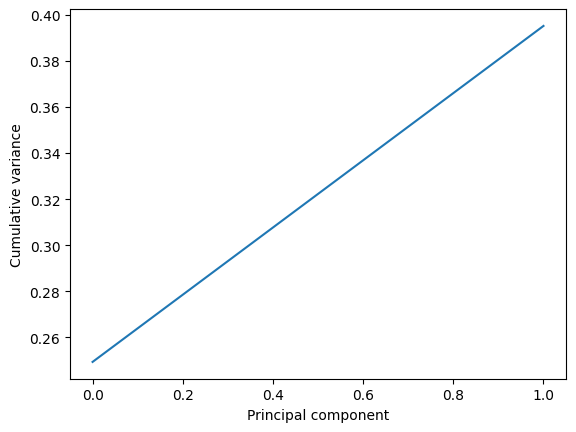

In [31]:
plt.plot(pc.cumulated_variance[:2])
plt.xlabel('Principal component')
plt.ylabel('Cumulative variance')
plt.show()

Visualising projections into a reduced dimensional space

In [32]:
transformed = pc.transform(backbone, n_components=2)
transformed.shape

(20001, 2)

In [33]:
df = pd.DataFrame(transformed,
                  columns=['PC{}'.format(i+1) for i in range(2)])
df['Time (ps)'] = df.index * u.trajectory.dt
df.head()

,PC1,PC2,Time (ps)
0,-0.653892,0.159673,0.0
1,0.809747,3.165507,5.0
2,1.986740,1.145884,10.0
3,0.817800,-3.058145,15.0
4,-0.375407,1.835483,20.0


In [58]:
df["PC1"]

0       -0.653892
1        0.809747
2        1.986740
3        0.817800
4       -0.375407
           ...   
19996    0.323793
19997    0.260865
19998   -0.041777
19999   -1.763191
20000   -2.335817
Name: PC1, Length: 20001, dtype: float64

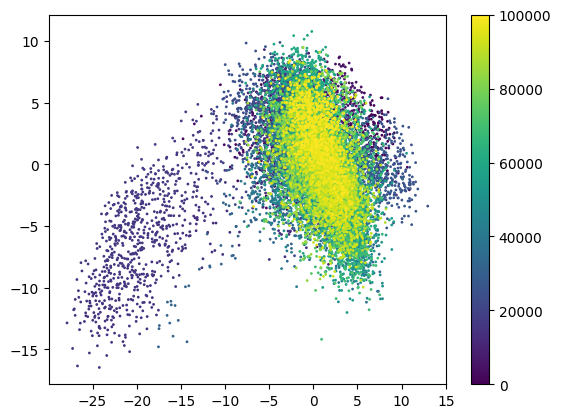

In [69]:
plt.scatter(df["PC1"],df["PC2"],s=1,cmap='viridis',c=(df["Time (ps)"]))
plt.colorbar()
plt.show()

Below, we generate the projected coordinates of the first principal component. The mean positions are stored at pc.mean.

In [39]:
pc1 = pc.p_components[:, 0]
trans1 = transformed[:, 0]
projected = np.outer(trans1, pc1) + pc.mean.flatten()
coordinates = projected.reshape(len(trans1), -1, 3)

In [40]:
proj1 = mda.Merge(backbone)
proj1.load_new(coordinates, order="fac")

<Universe with 223 atoms>

In [ ]:
import nglview as nv

In [43]:
from nglview.contrib.movie import MovieMaker
view = nv.show_mdanalysis(proj1.atoms)
view
movie = MovieMaker(
    view,
    step=4,  # keep every 4th frame
    output='pc1.gif',
    render_params={"factor": 3},  # set to 4 for highest quality
)
movie.make()

IntProgress(value=0, description='Rendering ...', max=5000)

Measuring convergence with cosine content

In [ ]:
for i in range(3):
    cc = pca.cosine_content(transformed, i)
    print(f"Cosine content for PC {i+1} = {cc:.3f}")

In [ ]:
# melt the dataframe into a tidy format
melted = pd.melt(df, id_vars=["Time (ps)"],
                 var_name="PC",
                 value_name="Value")
g = sns.FacetGrid(melted, col="PC")
g.map(sns.lineplot,
      "Time (ps)", # x-axis
      "Value", # y-axis
      ci=None) # no confidence interval
plt.show()

In [45]:
# This is for plot 
## Heatmap
## cubehelix
def plot_heatmap(ax,start,end):
    ## this is a histogram of the number of occurrences of the observations at (x[i],y[i]).
    ## bin: 'log', use a logarithmic scale for the color map. 
    ## Internally, log10(i+1) is used to determine the hexagon color. 
    ## vmin and vmax for colorbar range
    hb=ax.hexbin(x, y,
              cmap=sns.cubehelix_palette(dark=0,light=1,as_cmap=True),
              mincnt=1,
              bins='log',
              gridsize=50,
              vmin=0,
              vmax=2.6
              )
    # show color bar
    cb = fig.colorbar(hb, ax=ax)
    ax.set_xlabel("PC1", fontsize=16)
    ax.set_ylabel("PC2", fontsize=16)
## 
def plot_2dhist(ax,start,end):
    #range is decided by Rg and EED range
    plt.hist2d(x, y,bins=(50, 50), range=np.array([(0, 61), (2, 15)]),cmap=plt.cm.jet, normed=True)
    # show color bar
    cb = plt.colorbar()
    plt.clim(0,0.8)
    ax.tick_params(labelsize=30)
    cb.ax.tick_params(labelsize=25)
    ax.set_xlabel("PC1", fontsize=16)
    ax.set_ylabel("PC2", fontsize=16)
##
def plot_2dhist_v2(ax,start,end):
    h = hist2d.Hist2D(df)
    h.plot(bins=[50,50], cmap='hot_r', contour=False, normed=True, range=[[0,61],[2,15]],grid=False, colorbar=False, xlabel='', ylabel='')
    cb = plt.colorbar()
    plt.clim(0,0.8)
    ax.tick_params(labelsize=0)


# Saved data as a function of time
# namelist=["25","50","75","100", "200", "400","600","800","1000"]#,'1500','2000']#,"1200"]#,"1400"]#"1500","2000","2500","3000"] #, "d49y_f", "w53g_f"]
# framelst=["250","500","750","1000","2000","4000","6000","8000","10000"]#,"15000","20000"]#,"12000"]#,"14000"]#,"25000","30000"] #291221, 170032,   177390,   368855,   246110]

shift=0
start=0
inx=1
fig, ax = plt.subplots(figsize=(18, 15))
for i in range(0,9):
    plt.subplot(3,3,inx)

    txx1=np.loadtxt('1kdx_at-2rest3/2nd-cond/'+framelst[i]+'-res-len.dat')
    txx2=np.loadtxt('1kdx_at_ext-2rest3/2nd-cond/'+framelst[i]+'-res-len.dat')

    x1=txx1[:,0]
    y1=txx1[:,1]
    x2=txx2[:,0]
    y2=txx2[:,1]
    
    x=np.concatenate([x1,x2],axis=0)
    y=np.concatenate([y1,y2],axis=0)
   
    fname=namelist[i]
    H, xedges, yedges = np.histogram2d(x,y, bins=[10, 10], range=[[0,28],[2,15]],density=True)

    # plot 2d histogram in -log scale
    #fig, ax = plt.subplots(figsize=(6, 5))
    # shift minimum value to 0
    H_min=min(-1*np.log(H.T)[np.isfinite(np.log(H.T))])
    Z=-1*np.log(H.T)-H_min
    # heatmap
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]]
    plt.imshow(Z, aspect='auto', origin='lower', extent=extent, cmap=plt.cm.jet)
    # contour
    levels = np.arange(0, 3, 1)
    #ax.contour(Z, levels, colors='k', origin='lower', extent=extent)
    # colorbar
    cb = plt.colorbar()
    plt.clim(0,3)
    plt.text(1,13,fname+' ns',fontsize=45)
    #plt.legend(fontsize=14)
    #plt.
    #plt.xlabel('Residues',fontsize=16)
    #plt.ylabel('Length',fontsize=16)
    fig.tight_layout()
    plt.tick_params(axis='both', labelsize=30,direction='in',length=6)
    plt.rcParams['axes.linewidth'] = 4
    cb.ax.tick_params(labelsize=30)
    
    inx=inx+1
plt.savefig('/home/yumzhang/pikes_work/4-rest/paper_fig/svg_update/figs11.kid-rest3-PL-all.svg')

NameError: name 'fig' is not defined